In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats

sns.set(color_codes=True)

## Visualizing the distribution of a dataset

在获得样本数据后，我们可能会对其分布感兴趣。在了解数据大致分布情况下，我们可以更准确的进行模型假设。

### 单变量分布
在seaborn中，观察单变量分布最便捷的方式是使用`distplot()`。默认情况下，会绘制一个带有核密度估计（KDE）的直方图：

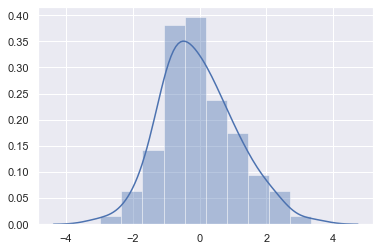

In [4]:
x = np.random.normal(size=100)
sns.distplot(x);

由直方图，我们可以看到数据的集中程度，以及大致分布情况。当然我们可以对`displot()`的参数进行调整，例如将KDE曲线去除，修改直方图中bin的数量, 添加`rug plot`(轴须图），即对每个观测，都用一个竖直的小轴(tick)表示:

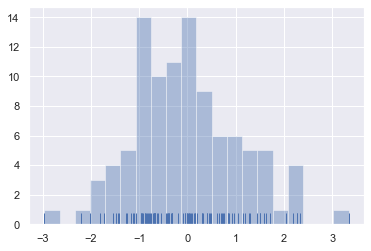

In [6]:
sns.distplot(x, kde=False, bins=20, rug=True);

甚至，我们可以把直方图隐藏，只显示KDE曲线：

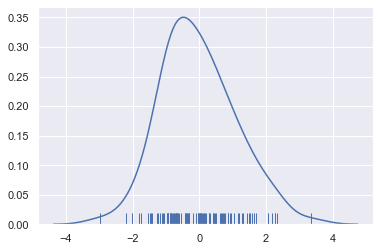

In [7]:
sns.distplot(x, hist=False, rug=True);

在seaborn中，默认的KDE使用的内核是高斯函数。当然，我们可以自定义内核函数：

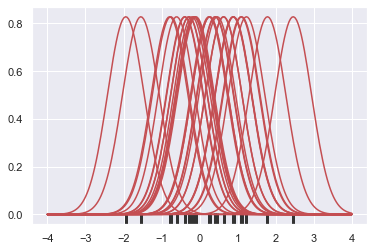

In [13]:
x = np.random.normal(0, 1, size=30)  # 标准正态分布
bandwidth = 1.06 * x.std() * x.size ** (-1/5.)  
support = np.linspace(-4, 4, 200)

# 核函数列表
kernels = []
for x_i in x:
    
    kernel = stats.norm(x_i, bandwidth).pdf(support)  # pdf默认为标准正态， loc=0, scale=1
    kernels.append(kernel)
    plt.plot(support, kernel, color='r')
    
sns.rugplot(x, color=".2", linewidth=3);

以上代码中，我们首先选择带宽为$1.06\hat{\sigma}n^{-1/5}$,这是内核函数为高斯时，最佳的[带宽选择](https://en.wikipedia.org/wiki/Kernel_density_estimation)。


对于`stats.norm(x_i, bandwidth)`，其首先生成以$x_i$为均值,带宽`bandwidth`为标准差的正态分布，然后再使用`pdf`方法，获取到其在[-4, 4]之间的所有取值。

然后再使用`plot`方法，绘制每个观察点$x_i$上替换的高斯函数。

接着，根据KDE的思想，我们将所有的内核函数累加"求平均"，获得估计函数

> "求平均"的意义其实是为了保证核函数求和后的密度函数，其曲线积分（即概率）为1.


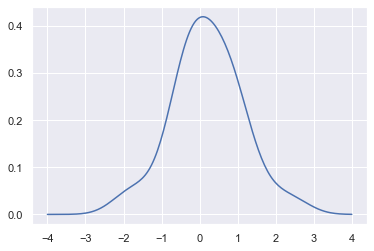

In [17]:
from scipy.integrate import trapz

density = np.sum(kernels, axis=0)  # 核函数累加获得估计密度函数
density /= trapz(density, support)
plt.plot(support, density);

`scipy.integrate`模块提供大量关于积分的计算工具，`trapz`方法可以对指定y值 (这里是density) 和积分变量x (这里是support,代表者元素间隔），计算y值与指定区间（这里是[-4,4]）之间围成的图形面积，即积分值。

这种KDE方法其实是seaborn中默认使用的方法，我们可以直接调用`kdeplot()`方法来查看：

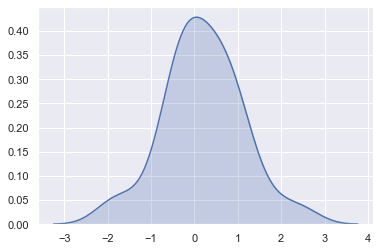

In [18]:
sns.kdeplot(x, shade=True);  

不难看出，上下两图完全一致。

因此，我们可以使用`kdeplot()`方法来更快速的定义KDE中的参数设置,例如调整带宽大小，来控制内核函数对数据的拟合程度 (how tightly the estimation is fit to the data).

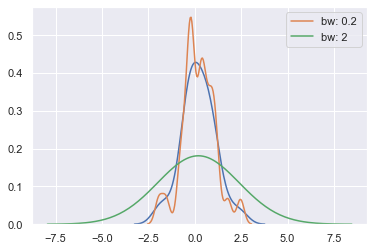

In [31]:
sns.kdeplot(x)
sns.kdeplot(x, bw=.2, label='bw: 0.2')
sns.kdeplot(x, bw=2 ,label='bw: 2')
plt.legend();

上图中，绿色曲线左右两端已经超出了x轴的范围，这是因为当我们带宽设置的比较大时，其KDE曲线可能会超出我们原有数据集中观察点x的范围。
因此，我们可以通过设置`cut`参数，控制曲线能够绘制多远的极限值。然而这只会影响曲线如何绘制，并不会影响曲线本身。

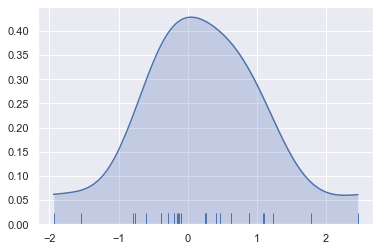

In [35]:
sns.kdeplot(x, shade=True, cut=0)
sns.rugplot(x);

---

除了使用KDE对分布进行估计之外，我们可以直接用指定的参数分布来观察拟合情况：

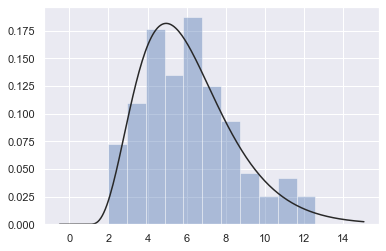

In [36]:
x = np.random.gamma(6, size=200)  # 随机生成gamma分布数据
# 使用gamma分布对数据拟合
sns.distplot(x, kde=False, fit=stats.gamma);

---

## Plotting bivariate distributions
在seaborn中对双变量的分布可视化也很简单，可以使用`jointplot()`方法，创建一个多表盘的图像，包含着两个变量之间的联合关系，同时也分别给出两个变量的边缘分布。

In [37]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)  # 二维正态分布，传入均值向量和协方差矩阵
df = pd.DataFrame(data, columns=['x', 'y'])

接着，我们使用`jointplot()`方法，对二维正态分布数据进行可视化，其默认会使用`scatterplot()`绘制散点图：

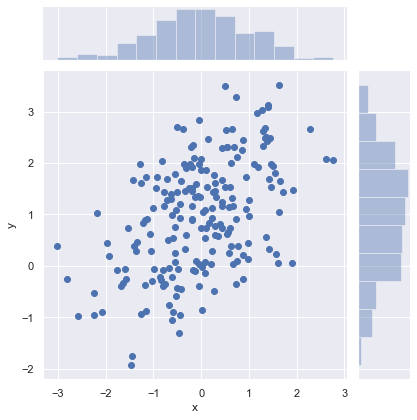

In [38]:
sns.jointplot(x='x', y='y', data=df);

对于较大的数据集，我们可以使用绘制六边形图，每个小六边形区域都代表着数据点的分布区域，六边形的颜色越深，代表者在该区域，数据分布的越密集：

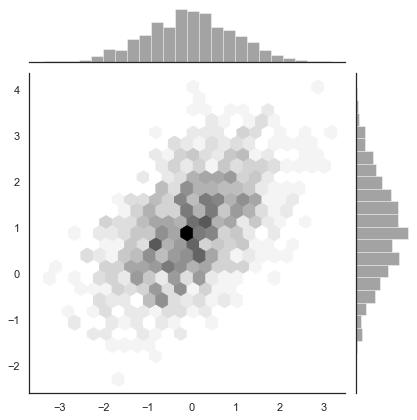

In [48]:
## hexbin plot
x, y = np.random.multivariate_normal(mean, cov, 1000).T

with sns.axes_style('white'):  # 设置轴的样式
    sns.jointplot(x=x, y=y, kind='hex', color='k');

✏ ： 这里我们对numpy生成的二维正态分布矩阵进行了转置，这是因为`np.random.multivariate_normal(mean, cov, 1000)`生成的矩阵是$1000\times 2$的矩阵，进行转置后，变为$2\times 1000$，于是才能对`x,y`分别赋值，否则会抛出`ValueError: too many values to unpack (expected 2)`的错误。

---

同样，我们可以对生成的随机二维正态分布数据使用KDE来估计分布的等高图：

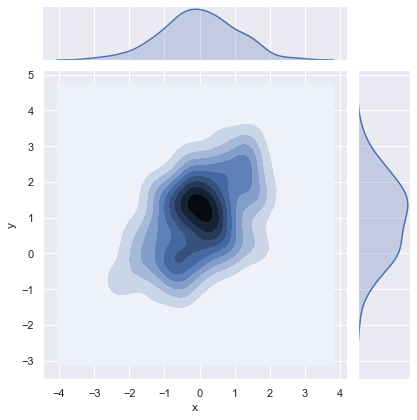

In [49]:
sns.jointplot(x='x', y='y', data=df, kind='kde');

或者我们直接在一个matplotlib的图例坐标轴上，使用`kdeplot()`来绘制样本的二维核密度函数图像：

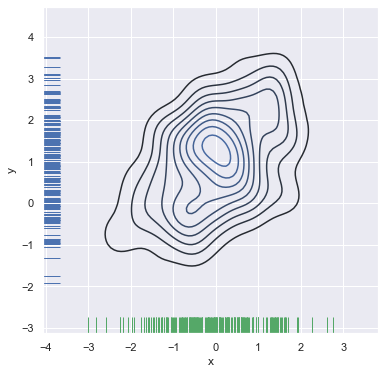

In [54]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df.x, df.y, ax=ax)  # 指定使用matplotlib图例的坐标轴
# 添加轴须图
sns.rugplot(df.x, color='g', ax=ax)
sns.rugplot(df.y, vertical=True, ax=ax);  # 将y数据放在竖轴上

如果我们想使得双变量密度分布更加连续，可以增加等高层的数量:

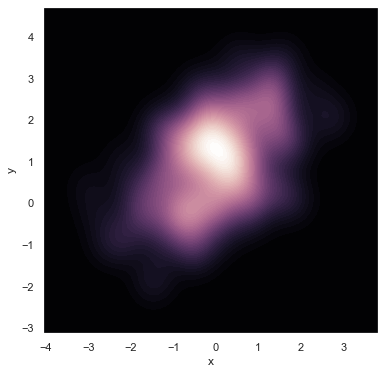

In [65]:
f, ax = plt.subplots(figsize=(6, 6))

# 创建调色板
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.x, df.y, cmap=cmap, n_levels=60, shade=True);

参数说明：

* `cubehelix_palette()`: 产生一个线性变化的colormap
    * `as_cmap`: 更改显示的颜色范围是离散列表的还是连续的调色板,；
    * `dark`, `light`: 设置调色版中最暗和最亮的程度，范围[0，1];
    * `reverse`: 默认为False，色彩由亮到暗;
* `kdeplot()`:
    * `cmap`: 传入调色板
    * `n_levels`: 控制KDE的区间个数，即在图像上的等高层数目

---

`jointplot()`使用`JointGrid`来管理图像，每次调用`jointplot()`函数都会返回一个`JointGrid`对象。

如果我们希望在`jointplot()`返回的图像基础上，再添加一些新的内容，可以直接对返回的`JointGrid`对象操作：

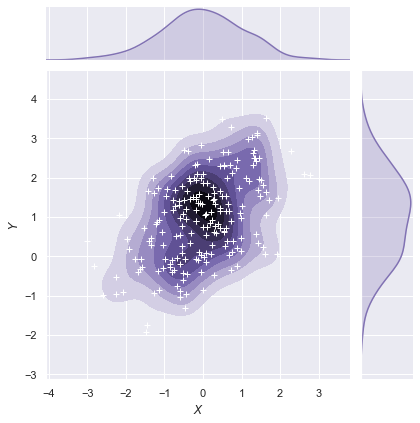

In [87]:
# 将jointplot返回的JointGrid对象赋予g
g = sns.jointplot(x='x', y='y', kind='kde', data=df, color='m')
g.plot_joint(plt.scatter, c='w', s=30, linewidth=1, marker='+')
g.ax_joint.collections[0].set_alpha(0)  # 绘制网格线
g.set_axis_labels('$X$', '$Y$');  # 添加坐标轴标签

* `plot_point`:
    * plt.scatter: 绘制数据散点图
    * `c='w'`: 标记符号的颜色
    * `s=30`: 标记符号的大小

---

## Visualizing pairwise relationships in a dataset
对于多个变量的联合关系可视化，我们可以使用`pairplot()`,对变量两两联合，返回一个pair-wise的双变量分布关系矩阵：

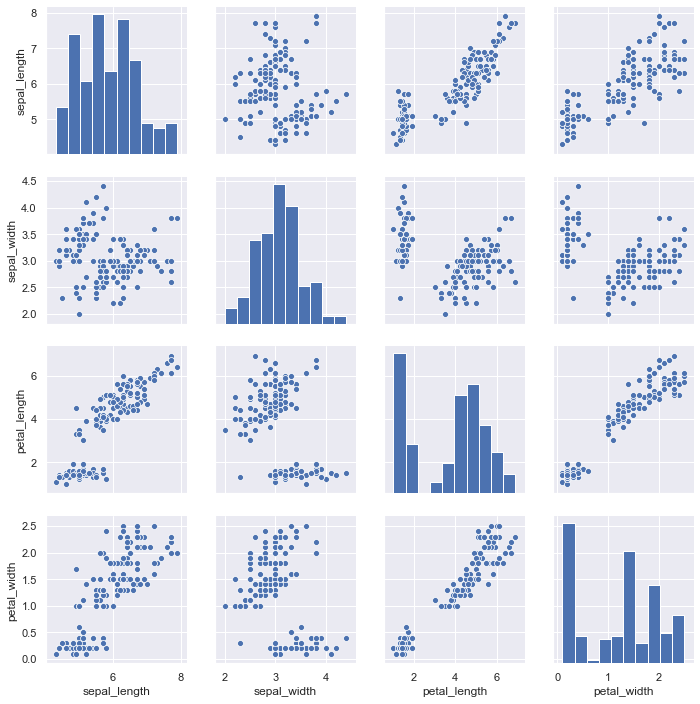

In [71]:
iris = sns.load_dataset('iris')  # 鸢尾花数据集
sns.pairplot(iris);

同时我们可以增加`hue`语义，此时会自动将直方图转为KDE虚线，更直观地表现不同变量分布之间的关系：

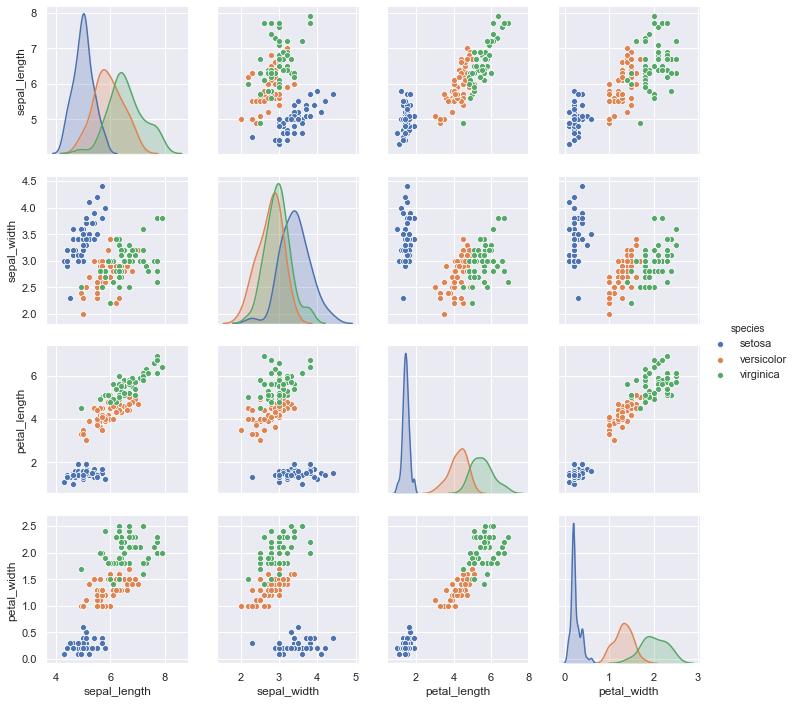

In [72]:
sns.pairplot(iris, hue='species');  # 根据鸢尾花的种类分类

---

与`jointplot()`类似，`pairplot()`创建后，会返回`PairGrid`对象，我们也可以在`PairGrid`上进行操作：

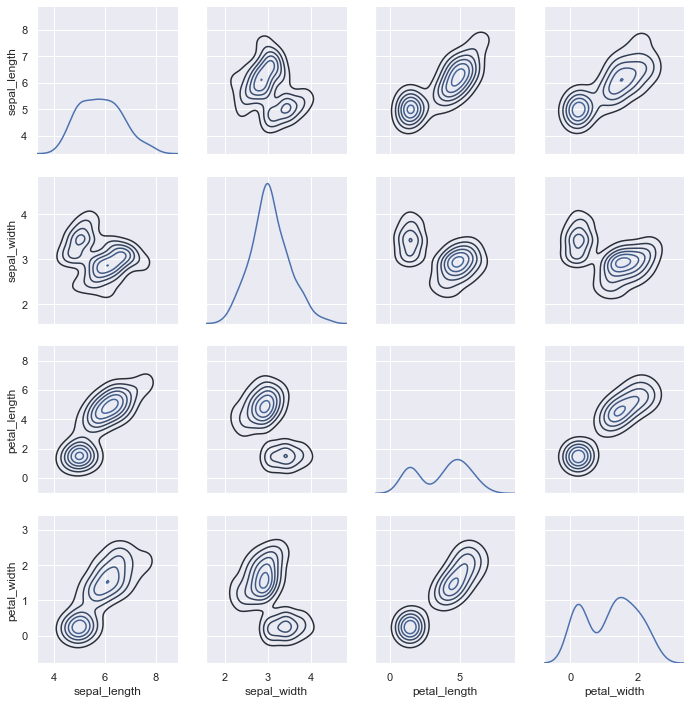

In [90]:
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot)  # 设置关系矩阵对角线上的图像类型
g.map_offdiag(sns.kdeplot, n_levels=6); # 设置非对角线上图像类型，并指定等高层数